In [1]:
import os, sys
sys.path.append("../")
sys.path.append("../../spectral_distortions_perturbations/")
sys.path.append("../../twentyone-global/")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.lines import Line2D
import matplotlib
from scipy.interpolate import interp1d
from tqdm import *

from grf.grf import FIRAS
from twentyone.twentyone import TwentyOne
from grf.pk_interp import PowerSpectrumGridInterpolator
from decay.units import *
from decay.decay import DecaySpectra

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
plots_dir = '../../spectral_distortions_perturbations/paper/draft-21cm-features/plots/'

## 21-cm and perturbation classes

In [4]:
# Define power spectrum for perturbations treatment
pspec = PowerSpectrumGridInterpolator("franken_lower")
firas = FIRAS(pspec)
spec_dapper = DecaySpectra(pspec)

../../spectral_distortions_perturbations/grf/grf.py:663: FutureWarning: read_table is deprecated, use read_csv instead.
  df = pd.read_table("../data/firas_monopole_spec_v1.txt", skiprows=18, sep="\s+", header=None, names=["freq", "I", "residual", "uncert", "poles"])


# Tests

### Comparisons with `ares`

In [34]:
f_star = 0.1
to = TwentyOne(z_min=10., z_max=40., f_star_L=f_star, f_star_X=f_star, T_vir_cut=1e4 * Kelv)

In [94]:
z_test = 10.

In [95]:
to.df_coll_dt_fstar(z_test) / f_star * Sec

3.626106604119206e-18

In [96]:
to.cosmo.critical_density0 * to.cosmo.Ob0

<Quantity 4.21083934e-31 g / cm3>

In [98]:
to.SFRD(z_test) / (M_s / Mpc ** 3 / Year)

0.07111325135116149

In [100]:
z_max = 30.
z_min = 11.
z_21_ary = np.logspace(np.log10(z_min), np.log10(z_max), 1000)[:: -1]

In [101]:
T_gamma_SM = lambda z: to.T_CMB(z)
to_SM_solve = TwentyOneSolver(T_gamma=T_gamma_SM, to=to, z_ary=z_21_ary)
to_SM_solution = to_SM_solve.solve()

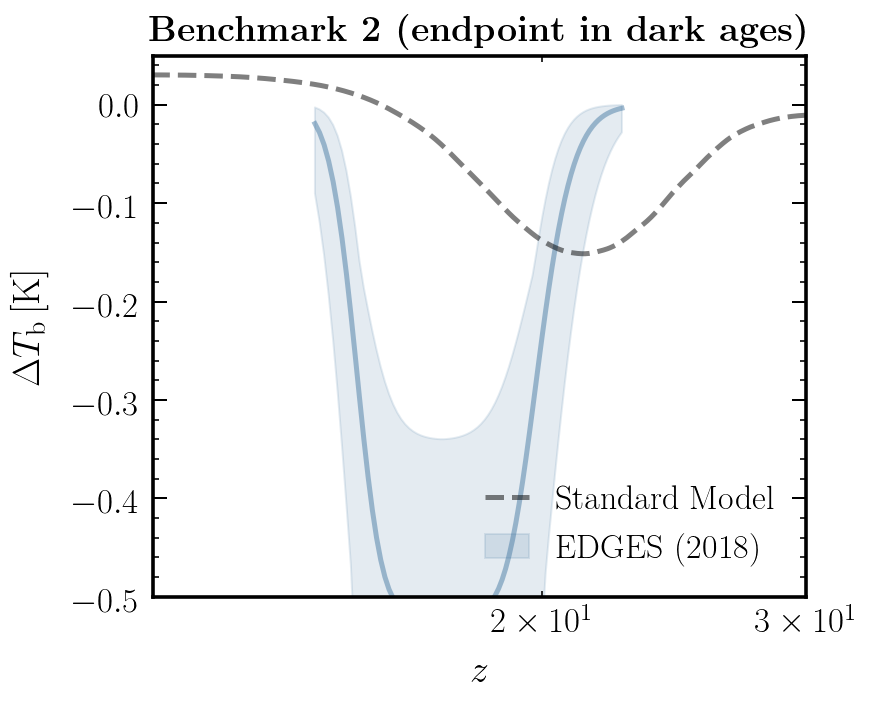

In [102]:
fig, ax = plt.subplots()

plt.plot(z_ary_EDGES,T21_EDGES, alpha=0.5, color=cols_default[1])
plt.fill_between(z_ary_EDGES, T21_EDGES_min, T21_EDGES_max, alpha=0.15, color=cols_default[1], label='EDGES (2018)')
plt.plot(to_SM_solve.z_ary, to_SM_solve.delta_T_b_ary, label='Standard Model', color='k', alpha=0.5, ls='--')

plt.xlabel("$z$")
plt.ylabel("$\Delta T_{\mathrm b}\,\mathrm{[K]}$")
plt.title(r"\bf{Benchmark 2} (endpoint in dark ages)")

plt.legend(loc='lower right', handlelength=1.3)

plt.xlim(np.min(to_SM_solve.z_ary), np.max(to_SM_solve.z_ary))

plt.xscale("log")

plt.ylim(-.5, 0.05)

plt.tight_layout()

## Parameter space scan

In [188]:
m_a_ary = np.logspace(-6, -1, 50) * eV
m_Ap_ary = np.logspace(-14, -9, 50) * eV

ratio_ary_100 = np.zeros((50, 50))
for i in range(len(m_Ap_ary)):
    filename = "/Users/smsharma/cluster_arys/chi2_arys/decay_" + str(i) + "_001.npz"
    if os.path.exists(filename):
        ratio_ary_100[i,:] = np.load(filename)['ratio_ary']
    else:
        continue
    
ratio_ary_100 = ratio_ary_100

In [189]:
z_res = np.array([spec_dapper.get_z_crossings(m_Ap, firas.omega_FIRAS[0])[-1] for m_Ap in m_Ap_ary])

z_end = 17.
m_a_end = (1 + z_res) / (z_end + 1) * spec_dapper.omega_21 * 2

In [191]:
lim_arcade_ary = np.zeros(len(ratio_ary_100))

for i_m in range(len(m_Ap_ary)):

    TS_eps_ary = np.nan_to_num(ratio_ary_100[i_m], nan=1e10)

    # Find value, location and xsec at the max TS (as a function of mass)
    max_loc = np.argmax(TS_eps_ary)
    max_TS = TS_eps_ary[max_loc]

    # Calculate limit
    for xi in range(max_loc, len(m_a_ary)):
        val = TS_eps_ary[xi]
        if val < 2.:
            scale = (-TS_eps_ary[xi - 1] + 2.) / (-TS_eps_ary[xi - 1] + TS_eps_ary[xi])
            lim_arcade_ary[i_m] = 10 ** (np.log10(m_a_ary[xi - 1]) + scale * (np.log10(m_a_ary[xi]) - np.log10(m_a_ary[xi - 1])))
            break
            
lim_arcade_ary[lim_arcade_ary == 0] = 1.
lim_arcade_ary[lim_arcade_ary < m_a_end] = 0.

In [192]:
ratio_ary_100 = np.zeros((50, 50))
for i in range(len(m_Ap_ary)):
    filename = "/Users/smsharma/cluster_arys/chi2_arys/decay_" + str(i) + "_100.npz"
    if os.path.exists(filename):
        ratio_ary_100[i,:] = np.load(filename)['ratio_ary']
    else:
        continue
    
ratio_ary_100 = ratio_ary_100

In [193]:
lim_stellar_ary = np.zeros(len(ratio_ary_100))

for i_m in range(len(m_Ap_ary)):

    TS_eps_ary = np.nan_to_num(ratio_ary_100[i_m], nan=1e10)

    # Find value, location and xsec at the max TS (as a function of mass)
    max_loc = np.argmax(TS_eps_ary)
    max_TS = TS_eps_ary[max_loc]

    # Calculate limit
    for xi in range(0, len(m_a_ary)):
        val = TS_eps_ary[xi]
        if val > 2.:
            scale = (-TS_eps_ary[xi - 1] + 2.) / (-TS_eps_ary[xi - 1] + TS_eps_ary[xi])
            lim_stellar_ary[i_m] = 10 ** (np.log10(m_a_ary[xi - 1]) + scale * (np.log10(m_a_ary[xi]) - np.log10(m_a_ary[xi - 1])))
            break
            
lim_stellar_ary[lim_stellar_ary == 0] = 1.
lim_stellar_ary[lim_stellar_ary < m_a_end] = 0.

In [194]:
ratio_ary_100 = np.zeros((50, 50))
for i in range(len(m_Ap_ary)):
    filename = "/Users/smsharma/cluster_arys/chi2_arys/decay_" + str(i) + "_010.npz"
    if os.path.exists(filename):
        ratio_ary_100[i,:] = np.load(filename)['ratio_ary']
    else:
        continue
    
ratio_ary_100 = ratio_ary_100

No handles with labels found to put in legend.


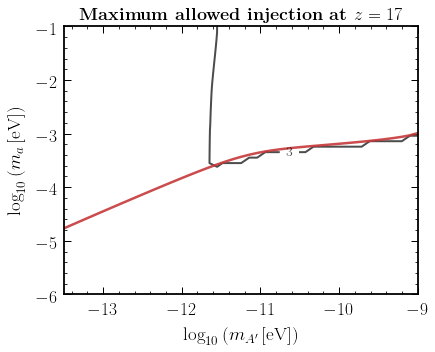

In [195]:
# mpl.rcParams['figure.figsize'] = 7.5, 5.5

ratio_ary_trans = np.transpose(ratio_ary_100)

levels = [3.]
X, Y = np.meshgrid(np.log10(m_Ap_ary / eV), np.log10(m_a_ary / eV))

fig, ax = plt.subplots()

CS = ax.contour(X, Y, ratio_ary_trans, levels = levels, linestyles=['-','--'], colors='k', linewidths=2, alpha=0.7)

fmt = {}
strs = ['3']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
    
# im = ax.imshow((ratio_ary_trans), cmap = 'YlGn', aspect='auto', origin='lower', extent=[-14, -9, -5, -1], vmin=1, vmax=10)

ax.clabel(CS, fmt=fmt,inline=1, fontsize=14)
ax.plot(np.log10(m_Ap_ary / eV), np.log10(m_a_end / eV))
# ax.plot(np.log10(m_A_ary / eV), np.log10(m_a_EDGES_ary / eV), color='blue', label='$z_\mathrm{end} = 15$')

# cbar = fig.colorbar(im)
# cbar.set_label(r'$\log_{10}(T_A^{\mathrm{max}} / T_{\mathrm{CMB}})_{z=17}$')

ax.set_xlabel('$\log_{10}\,(m_{A^\prime}\,[\mathrm{eV}])$')
ax.set_ylabel('$\log_{10}\,(m_a\,[\mathrm{eV}])$')

ax.set_xlim(-13.5, -9)
ax.set_ylim(-6, -1)

plt.legend(loc='lower right', ncol=2)

plt.title(r"\bf{Maximum allowed injection at $z=17$}")

plt.tight_layout()


In [196]:
m_radio, lim_radio = np.transpose((CS.collections[0].get_paths()[0].vertices)[:-12])

In [254]:
m_Ap_fine_ary = np.logspace(-14, np.max(m_radio), 20000) * eV
z_res = np.array([spec_dapper.get_z_crossings(m_Ap, firas.omega_FIRAS[0])[-1] for m_Ap in m_Ap_fine_ary])

z_end = 17.
m_a_fine_end = (1 + z_res) / (z_end + 1) * spec_dapper.omega_21 * 2

In [255]:
lim_radio_interp = interp1d(m_radio, lim_radio, bounds_error=False)(np.log10(m_Ap_fine_ary / eV))

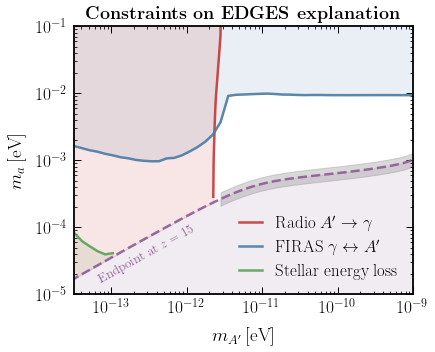

In [257]:
# m_radio, lim_radio = np.transpose([[-11.61534244,  -1.        ],
#        [-11.61709444,  -1.10204082],
#        [-11.61925016,  -1.20408163],
#        [-11.62161559,  -1.30612245],
#        [-11.62415657,  -1.40816327],
#        [-11.62682733,  -1.51020408],
#        [-11.62957337,  -1.6122449 ],
#        [-11.63233609,  -1.71428571],
#        [-11.63505762,  -1.81632653],
#        [-11.63768525,  -1.91836735],
#        [-11.64017461,  -2.02040816],
#        [-11.64244807,  -2.12244898],
#        [-11.64421321,  -2.2244898 ],
#        [-11.64554981,  -2.32653061],
#        [-11.64677875,  -2.42857143],
#        [-11.64791921,  -2.53061224],
#        [-11.64896183,  -2.63265306],
#        [-11.65107244,  -2.73469388],
#        [-11.65283401,  -2.83673469],
#        [-11.65306122,  -2.92638765],
#        [-11.65432389,  -2.93877551],
#        [-11.65936234,  -3.04081633],
#        [-11.66308567,  -3.14285714],
#        [-11.66618721,  -3.24489796],
#        [-11.66875328,  -3.34693878],
#        [-11.66996249,  -3.44897959],
#        [-11.65306122,  -3.52350079],
#        [-11.65204628,  -3.55102041]])

lim_stellar_ary[m_Ap_ary / eV > 1.2e-13] = np.nan #m_a_end[m_Ap_ary / eV > 1.5e-13]

fig, ax = plt.subplots()

ax.plot(m_Ap_fine_ary / eV, 10 ** lim_radio_interp, label=r"Radio $A'\rightarrow\gamma$", color=cols_default[0])
# ax.plot(10 ** m_radio, 10 ** lim_radio, label=r"Radio $A'\rightarrow\gamma$", color=cols_default[0])
ax.plot(m_Ap_ary / eV, lim_arcade_ary / eV, label=r"FIRAS $\gamma\leftrightarrow A'$", color=cols_default[1])
ax.plot(m_Ap_ary[m_Ap_ary / eV < 3e-13] / eV, lim_stellar_ary[m_Ap_ary / eV < 3e-13] / eV, label=r"Stellar energy loss", color=cols_default[2])
ax.plot(m_Ap_ary / eV, m_a_end / eV, ls='--', color=cols_default[3])

ax.fill_between(m_Ap_ary / eV, lim_arcade_ary / eV, np.ones_like(lim_arcade_ary), color=cols_default[1], alpha=0.12)
ax.fill_between(m_Ap_ary / eV, lim_stellar_ary / eV, m_a_end / eV, color=cols_default[2], alpha=0.12)
ax.fill_between(m_Ap_ary / eV, m_a_end / eV, 1e-8 * np.ones_like(m_a_end / eV), color=cols_default[3], alpha=0.12)

mean_radio = np.min(10 ** m_radio)
offset = 0
# ax.fill_between(m_Ap_ary[m_Ap_ary / eV < mean_radio - offset] / eV, m_a_end[m_Ap_ary / eV < mean_radio - offset] / eV, np.ones_like(m_a_end[m_Ap_ary / eV < mean_radio - offset]) / eV, color=cols_default[0], alpha=0.12)
# ax.fill_between(10 ** m_radio, 10 ** lim_radio, np.ones_like(10 ** lim_radio), color=cols_default[0], alpha=0.12)
# ax.fill_between(m_Ap_fine_ary / eV, 10 ** lim_radio_interp, np.ones_like(10 ** lim_radio_interp), color=cols_default[0], alpha=0.12)

fill_lower = np.max([m_a_fine_end / eV, np.nan_to_num(10 ** lim_radio_interp)], axis=0)
ax.fill_between(m_Ap_fine_ary / eV, fill_lower, np.ones_like(10 ** lim_radio_interp), color=cols_default[0], alpha=0.12)



ax.fill_between(m_Ap_ary[m_Ap_ary / eV > mean_radio] / eV, 10 ** (np.log10(m_a_end[m_Ap_ary / eV > mean_radio] / eV) - 0.1), 10 ** (np.log10(m_a_end[m_Ap_ary / eV > mean_radio] / eV) + 0.1), color='grey', alpha=0.3)

ax.set_xlabel('$m_{A^\prime}\,[\mathrm{eV}]$')
ax.set_ylabel('$m_a\,[\mathrm{eV}]$')

ax.set_xlim(10 ** -13.5, 10 ** -9)
ax.set_ylim(10 ** -5, 10 ** -1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.text(6.3e-14, 1.5e-5, 'Endpoint at $z=15$', rotation=29, fontsize=13, color=cols_default[3])
# ax.text(1e-11, 1e-4, 'Can explain EDGES \n amplitude and upturn', rotation=6, fontsize=13, color='black')

ax.legend(handlelength=1.3)

plt.title(r"\bf{Constraints on EDGES explanation}")
plt.tight_layout()

# plt.savefig(plots_dir + "EDGES_param.pdf")
plt.savefig("/Users/smsharma/Desktop/EDGES_param.pdf")